# GlobeStay Marketing Response Models (by Country)

**Channels (Digital Awareness):**
*   display (display_net_spend_eur) (dp_imps)
*   Youtube (yt_cost) (yt_imps)
*   Facebook (fb_cost) (fb_imps)
*   OLV (olv_spend_eur) (olv_imps)

**Models:**
1. A **log–log** (OLS) model (elasticities directly from coefficients)
2. An **ADBUDG** response model (nonlinear saturation: \(f(X)=a\,X^c/(X^c+d)\))

**Controls included:**
- Competition: `meta_comp_grp`, `ota_comp_grp` (log1p transformed)
- Seasonality: weekly Fourier terms (K=2)
- Trend: per-country time index
- Holidays: specified dummy columns (binary)

**Outputs:**
- Elasticities & marginal ROI (bookings per currency unit) for both models
- Diagnostic plots and response curves (matplotlib only, one chart per figure)
- Next-dollar **budget allocation recommendations** (raw & adjusted)

> **Note:** Financial ROI requires a contribution per booking. Here we report *bookings per currency*. Multiply by average contribution per booking to convert to financial ROI.

In [50]:
# Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from scipy.optimize import least_squares

pd.set_option('display.max_columns', 150)
plt.rcParams.update({'figure.dpi': 120})

# Parameters
DATA_PATH = '/content/cleaned_globestay.csv'
OUTPUT_DIR = '/content/output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
df = pd.read_csv(DATA_PATH)
df.head()


,sales_direct,olv_imps,value_currency_rate,thanksgivingday_us_ca,cost_remarketing,martinl_kingsday_us_ca,presidentsday_us_ca,independenceday_us_ca,meta_comp_grp,cost_ppc_non_brand,boxingday,sales_emk,eastermonday,sales_ppc_brand,olv_net_spend_eur,eastersunday,radio_net_spend_eur,labourday_de_nw,sales_shop_tripadvisor,clicks_remarketing,sales_interco,mayday_gb_en,sales_shop_googleha,cost_email,sales_strat_part,fb_imps,remembrance_memorialday_us_ca,fb_cost,clicks_shop_trivago,clicks_email,cost_shop_other,brandtv_net_spend_eur,clicks_shop_other,country,weekstart,clicks_shop_googleha,display_imps,cost_ppc_brand,christmasday,christsascensionday_de_nw,cost_shop_tripadvisor,drtv_grp,ooh_net_spend_eur,yt_cost,newyearsday,sales_shop_trivago,stvalentinesday,display_net_spend_eur,whitmonday_de_nw,germanunityday_de_nw,bankholiday_gb_en,ota_comp_grp,clicks_shop_tripadvisor,cost_shop_trivago,sales_retargeting,cost_shop_googleha,cinema_net_spend_eur,sales_shop_other,totbookings,yt_imps,sales_ppc_nonbrand,clicks_ppc_non_brand,print_net_spend_eur,drtv_net_spend_eur,brandtv_grp,clicks_ppc_brand,labourday_us_ca,_source_sheet,country_std,week_start
0,183169.0,0.0,1.0,0.0,58684.506092,0.0,0.0,0.0,926.0,2.196494e+06,0.0,16703.0,0.0,48228.0,0.0,0.0,0.0,0.0,9503.0,172069.878486,867.0,0.0,10423.0,0.0,16547.0,0.0,0.0,0.000000,8.478270e+05,474859.0,103139.320644,0.0,250527.000002,de,2016-01-04,133462.122833,0.0,68560.240287,0.0,0.0,283108.460235,0.0,0.0,0.000000,0.0,18302.0,0.0,0.0,0.0,0.0,0.0,321.0,367987.978037,377911.565361,2040.0,170087.676546,0.0,4678.0,398268.0,12.0,87808.0,2.496438e+06,0.0,0.0,0.0,378640.216496,0.0,Sheet1,58684.506092,NaN
1,184480.0,0.0,1.0,0.0,76380.207088,0.0,0.0,0.0,706.0,2.306422e+06,0.0,16278.0,0.0,49076.0,0.0,0.0,0.0,0.0,9143.0,198123.396746,858.0,0.0,11107.0,0.0,17340.0,57831.0,0.0,89.386325,9.612325e+05,478024.0,116137.878276,0.0,278878.649717,de,2016-01-11,136016.480131,0.0,70502.248076,0.0,0.0,257639.565836,0.0,0.0,0.000000,0.0,21148.0,0.0,0.0,0.0,0.0,0.0,225.0,353354.844840,471254.197728,2236.0,193176.386595,0.0,5019.0,404068.0,247.0,87383.0,2.520208e+06,0.0,0.0,0.0,386722.377913,0.0,Sheet1,76380.207088,NaN
2,178895.0,0.0,1.0,0.0,81636.483459,1.0,0.0,0.0,813.0,2.379034e+06,0.0,15822.0,0.0,45575.0,0.0,0.0,0.0,0.0,8568.0,186402.476444,806.0,0.0,10048.0,0.0,16873.0,104754.0,0.0,231.027642,9.127736e+05,482391.0,116345.872180,0.0,288057.500725,de,2016-01-18,126167.255474,0.0,61647.322276,0.0,0.0,247711.892237,0.0,0.0,1.459669,0.0,19715.0,0.0,0.0,0.0,0.0,0.0,231.0,332119.415416,439863.176592,2224.0,191568.477802,0.0,4963.0,388746.0,10249.0,85257.0,2.538803e+06,0.0,0.0,0.0,372694.075197,0.0,Sheet1,81636.483459,NaN
3,178961.0,0.0,1.0,0.0,97974.916607,0.0,0.0,0.0,1249.0,2.342182e+06,0.0,15441.0,0.0,46037.0,0.0,0.0,0.0,0.0,8065.0,203471.161091,770.0,0.0,10234.0,0.0,17386.0,0.0,0.0,0.000000,1.063155e+06,477310.0,117989.868406,0.0,281681.767054,de,2016-01-25,127212.718534,0.0,58113.630201,0.0,0.0,220940.048133,0.0,0.0,4.025302,0.0,22804.0,0.0,0.0,0.0,0.0,0.0,224.0,299462.651303,499118.517506,2498.0,210296.033518,0.0,5266.0,391945.0,6144.0,84483.0,2.520338e+06,0.0,0.0,0.0,367930.614827,0.0,Sheet1,97974.916607,NaN
4,178238.0,0.0,1.0,0.0,95282.006389,0.0,0.0,0.0,772.0,2.242276e+06,0.0,15610.0,0.0,45020.0,0.0,0.0,0.0,0.0,7610.0,205548.009831,807.0,0.0,10490.0,0.0,17840.0,248451.0,0.0,476.436307,1.059135e+06,475233.0,123253.978573,0.0,259377.433805,de,2016-02-01,130732.603895,0.0,56688.931152,0.0,0.0,204314.700744,0.0,0.0,0.009987,0.0,23259.0,0.0,0.0,0.0,0.0,0.0,341.0,281375.925071,487391.446449,2481.0,214412.055927,0.0,5186.0,389989.0,2.0,83448.0,2.354455e+06,0.0,0.0,0.0,352899.330762,0.0,Sheet1,95282.006389,NaN


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 70 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sales_direct                   576 non-null    float64
 1   olv_imps                       576 non-null    float64
 2   value_currency_rate            576 non-null    float64
 3   thanksgivingday_us_ca          576 non-null    float64
 4   cost_remarketing               576 non-null    float64
 5   martinl_kingsday_us_ca         576 non-null    float64
 6   presidentsday_us_ca            576 non-null    float64
 7   independenceday_us_ca          576 non-null    float64
 8   meta_comp_grp                  576 non-null    float64
 9   cost_ppc_non_brand             576 non-null    float64
 10  boxingday                      576 non-null    float64
 11  sales_emk                      576 non-null    float64
 12  eastermonday                   576 non-null    flo

In [52]:
SELECTED_COLS_DIGITAL = [
    # Competition
    'meta_comp_grp','ota_comp_grp',
    # Controls
    'country','weekstart',
    # Holidays
    'presidentsday_us_ca','labourday_de_nw','boxingday','eastermonday','martinl_kingsday_us_ca',
    'remembrance_memorialday_us_ca','independenceday_us_ca','stvalentinesday','eastersunday',
    'christsascensionday_de_nw','labourday_us_ca','whitmonday_de_nw','bankholiday_gb_en',
    'thanksgivingday_us_ca','germanunityday_de_nw','mayday_gb_en','newyearsday','christmasday',
    # Digital Channels (Cost and Impressions)
    'display_net_spend_eur','display_imps',
    'yt_cost','yt_imps',
    'fb_cost','fb_imps',
    'olv_net_spend_eur','olv_imps',
    # Currency normalization
    'value_currency_rate',
]


In [53]:
# Load data (only selected columns for digital channels)
df = pd.read_csv(DATA_PATH)  # make sure DATA_PATH points to your digital data file
df = df[[c for c in SELECTED_COLS_DIGITAL if c in df.columns]].copy()
df['weekstart'] = pd.to_datetime(df['weekstart'])
countries = sorted(df['country'].dropna().unique().tolist())

# Display first 3 rows and basic info
display(df.head(3))
print('Rows:', len(df), '| Countries:', countries)


,meta_comp_grp,ota_comp_grp,country,weekstart,presidentsday_us_ca,labourday_de_nw,boxingday,eastermonday,martinl_kingsday_us_ca,remembrance_memorialday_us_ca,independenceday_us_ca,stvalentinesday,eastersunday,christsascensionday_de_nw,labourday_us_ca,whitmonday_de_nw,bankholiday_gb_en,thanksgivingday_us_ca,germanunityday_de_nw,mayday_gb_en,newyearsday,christmasday,display_net_spend_eur,display_imps,yt_cost,yt_imps,fb_cost,fb_imps,olv_net_spend_eur,olv_imps,value_currency_rate
0,926.0,321.0,de,2016-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,12.0,0.000000,0.0,0.0,0.0,1.0
1,706.0,225.0,de,2016-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,247.0,89.386325,57831.0,0.0,0.0,1.0
2,813.0,231.0,de,2016-01-18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.459669,10249.0,231.027642,104754.0,0.0,0.0,1.0


Rows: 576 | Countries: ['de', 'gb', 'us']


In [61]:
# Feature engineering for digital channels
# Seasonality features
df = df.sort_values(['country','weekstart']).copy()
df['t'] = df.groupby('country').cumcount() + 1
df['woy'] = df['weekstart'].dt.isocalendar().week.astype(int)

# FX-normalize digital channel costs
rate = df['value_currency_rate'].replace(0, np.nan).fillna(1.0)
for col in ['display_net_spend_eur', 'yt_cost', 'fb_cost', 'olv_net_spend_eur']:
    df[col+'_normalized'] = df[col] / rate


# Add Fourier terms
def add_fourier_terms(df_sub, K=2):
    for k in range(1, K+1):
        df_sub[f'sin_{k}'] = np.sin(2*np.pi*k*df_sub['woy']/52.0)
        df_sub[f'cos_{k}'] = np.cos(2*np.pi*k*df_sub['woy']/52.0)
    return df_sub

df = pd.concat(
    [add_fourier_terms(g.copy(), K=2).assign(country=iname) for iname, g in df.groupby('country')],
    axis=0,
)

# Fill NA holiday dummies with 0
holiday_cols = [
    'presidentsday_us_ca','labourday_de_nw','boxingday','eastermonday','martinl_kingsday_us_ca',
    'remembrance_memorialday_us_ca','independenceday_us_ca','stvalentinesday','eastersunday',
    'christsascensionday_de_nw','labourday_us_ca','whitmonday_de_nw','bankholiday_gb_en',
    'thanksgivingday_us_ca','germanunityday_de_nw','mayday_gb_en','newyearsday','christmasday'
]
df[holiday_cols] = df[holiday_cols].fillna(0)

# Create total impressions variable across all 4 digital channels
df['total_imps'] = df[['display_imps','yt_imps','fb_imps','olv_imps']].sum(axis=1)



## Log–log model by country
- Spec: `log(imps+1)` vs. `log(cost_*_normalized+1)
- HAC robust SE with `maxlags=4`.
- Elasticities = coefficients on log-costs.

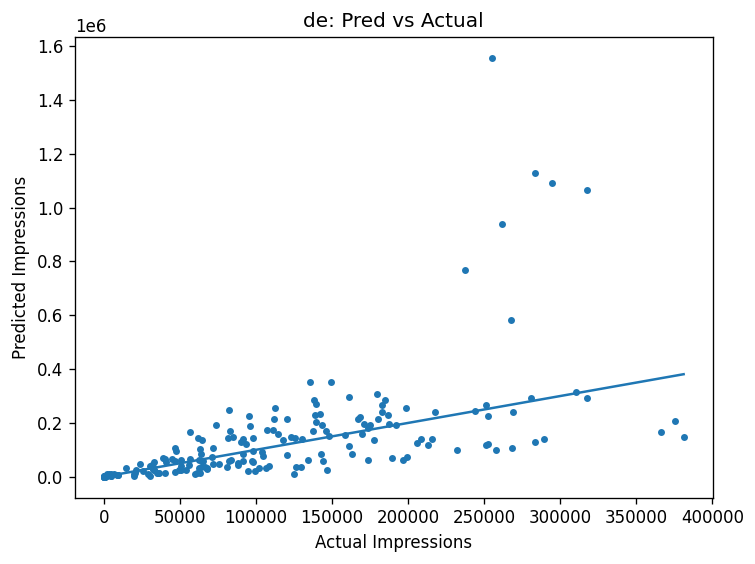

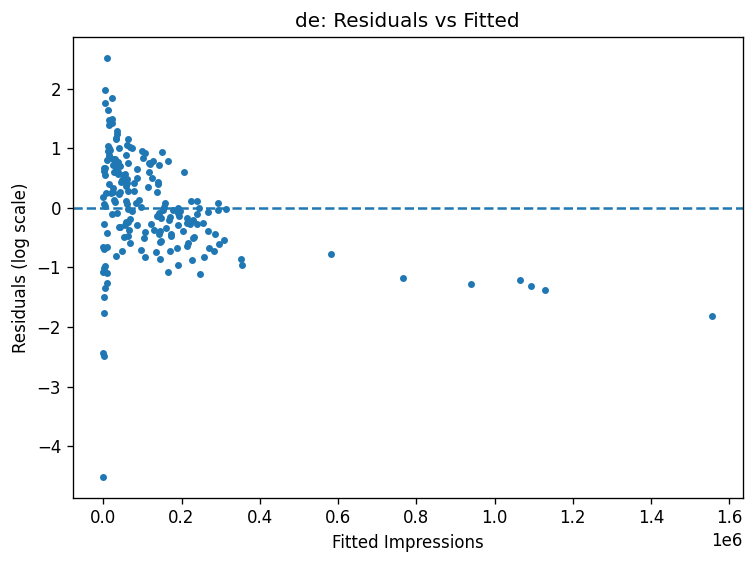

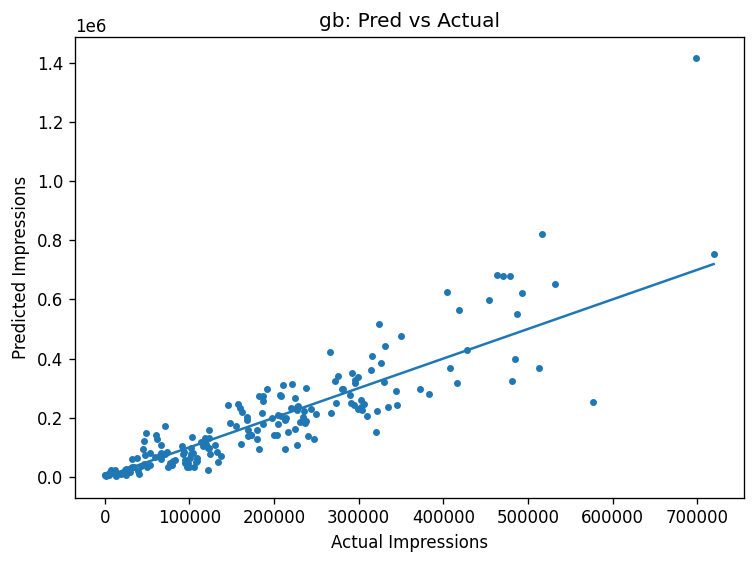

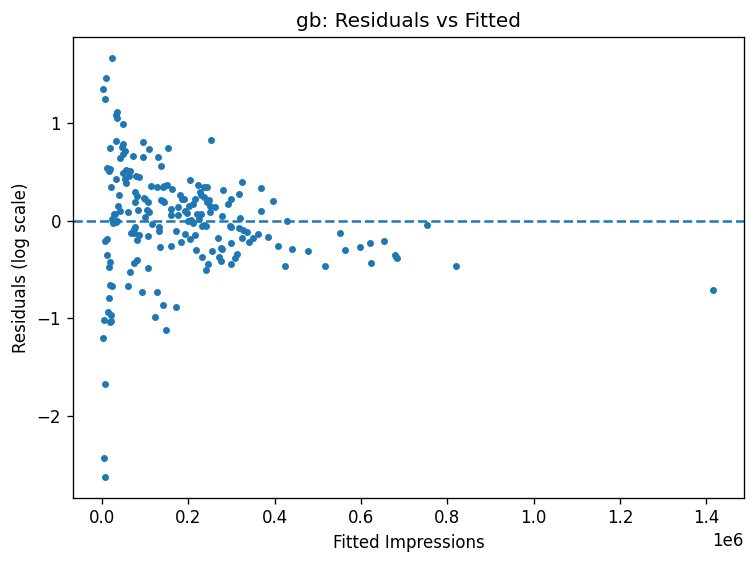

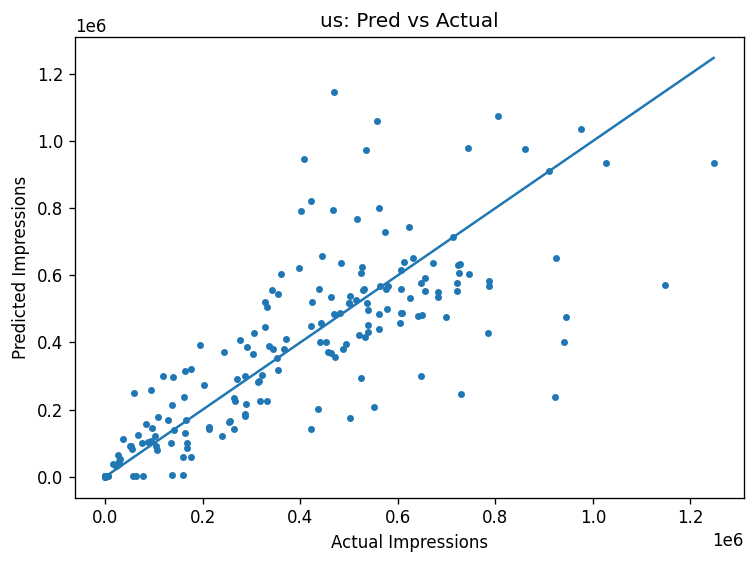

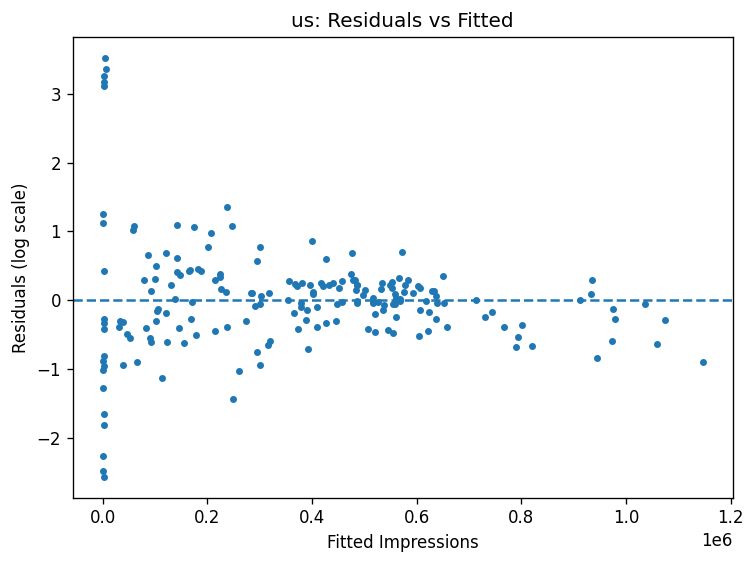

### Elasticities (Log-Log)

,country,channel,elasticity_loglog
0,de,Display,0.055525
1,de,YouTube,0.120726
2,de,Facebook,0.137616
3,de,OLV,0.220910
4,gb,Display,0.094996
5,gb,YouTube,0.047297
6,gb,Facebook,0.154978
7,gb,OLV,0.085721
8,us,Display,0.360471
9,us,YouTube,0.008226


### Marginal Impressions per Dollar (Log-Log)

,country,channel,marginal_impressions_per_dollar_loglog
0,de,Display,0.211764
1,de,YouTube,0.335287
2,de,Facebook,0.344063
3,de,OLV,0.585543
4,gb,Display,0.200558
5,gb,YouTube,0.165122
6,gb,Facebook,0.448234
7,gb,OLV,0.559308
8,us,Display,0.767732
9,us,YouTube,0.031490


In [65]:
# Log–log model by country for total digital impressions
def fit_loglog_country_imps(dfc, channels):
    # Y: sum of impressions across channels
    y = np.log1p(dfc[[col for _, col in channels]].sum(axis=1))

    # X: ln(cost) of each channel + controls
    X = pd.DataFrame({f'ln_cost_{ch.lower()}': np.log1p(dfc[col]) for ch, col in channels})
    X['meta_comp_grp'] = dfc['meta_comp_grp']
    X['ota_comp_grp']  = dfc['ota_comp_grp']
    X['t']             = dfc['t']
    X['sin_1']         = dfc['sin_1']
    X['cos_1']         = dfc['cos_1']
    X['sin_2']         = dfc['sin_2']
    X['cos_2']         = dfc['cos_2']
    X[holiday_cols]    = dfc[holiday_cols]
    X = add_constant(X, has_constant='add')

    model = OLS(y, X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':4})
    return model, X, y

# Define digital channels
channels_digital = [
    ('Display', 'display_net_spend_eur'),
    ('YouTube', 'yt_cost'),
    ('Facebook', 'fb_cost'),
    ('OLV', 'olv_net_spend_eur')
]

loglog_results = {}
elasticity_rows, roi_rows = [], []

# Fit models and compute diagnostics
for ctry in countries:
    dsub = df[df['country']==ctry].copy()
    if len(dsub) < 30:
        display(Markdown(f"**Skipping {ctry}**: not enough data"))
        continue

    mdl, X, y = fit_loglog_country_imps(dsub, channels_digital)
    loglog_results[ctry] = mdl
    yhat = mdl.predict(X)

    # Diagnostics: predicted vs actual (levels)
    plt.figure()
    plt.scatter(np.expm1(y), np.expm1(yhat), s=10)
    lo, hi = float(np.expm1(y).min()), float(np.expm1(y).max())
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel('Actual Impressions'); plt.ylabel('Predicted Impressions'); plt.title(f'{ctry}: Pred vs Actual')
    plt.tight_layout(); plt.show(); plt.close()

    # Residuals vs fitted
    resid = y - yhat
    plt.figure()
    plt.scatter(np.expm1(yhat), resid, s=10)
    plt.axhline(0, linestyle='--')
    plt.xlabel('Fitted Impressions'); plt.ylabel('Residuals (log scale)'); plt.title(f'{ctry}: Residuals vs Fitted')
    plt.tight_layout(); plt.show(); plt.close()

    # Elasticities and marginal impressions per dollar
    elasticities = {ch: mdl.params.get(f'ln_cost_{ch.lower()}', np.nan) for ch, _ in channels_digital}
    mean_Y = np.expm1(y).mean()
    mean_costs = {ch: dsub[col].replace(0,np.nan).mean() for ch, col in channels_digital}

    for ch, beta in elasticities.items():
        Xbar = mean_costs.get(ch, np.nan)
        if np.isnan(beta) or Xbar <= 0:
            m_ipd = np.nan
        else:
            m_ipd = beta * (mean_Y / Xbar)  # marginal impressions per dollar
        elasticity_rows.append({'country': ctry, 'channel': ch, 'elasticity_loglog': beta})
        roi_rows.append({'country': ctry, 'channel': ch, 'marginal_impressions_per_dollar_loglog': m_ipd})

elasticity_df = pd.DataFrame(elasticity_rows)
roi_df = pd.DataFrame(roi_rows)

display(Markdown('### Elasticities (Log-Log)'))
display(elasticity_df)
display(Markdown('### Marginal Impressions per Dollar (Log-Log)'))
display(roi_df)



## ADBUDG model (nonlinear saturation) by country
Controls-only baseline → incremental bookings → ADBUDG curves per channel combined.

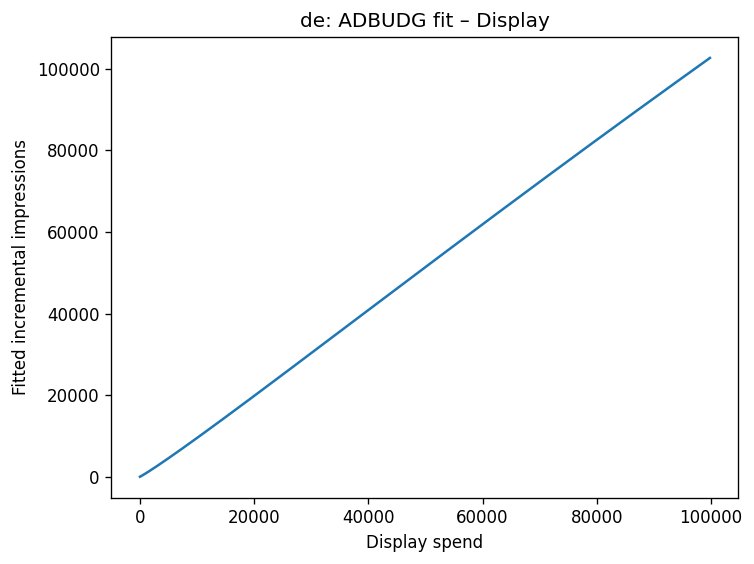

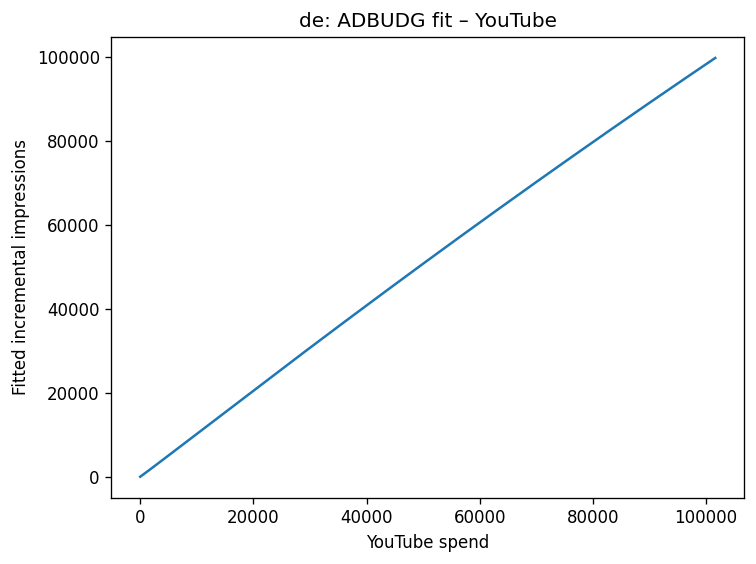

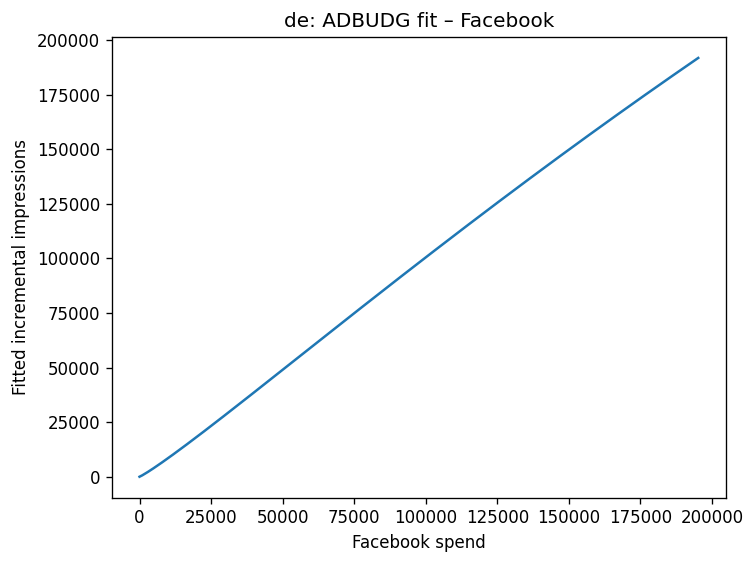

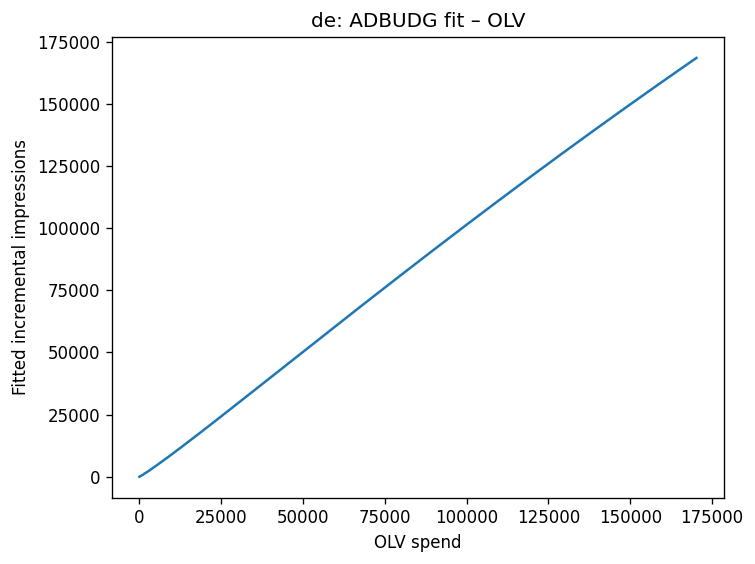

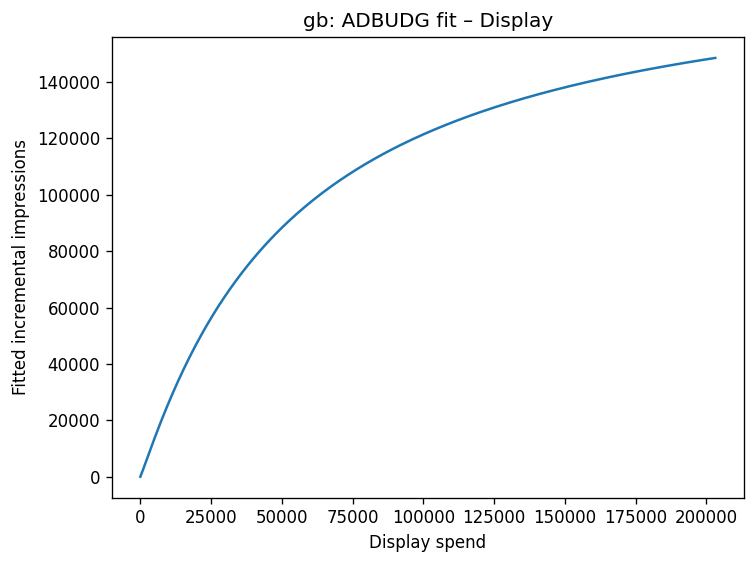

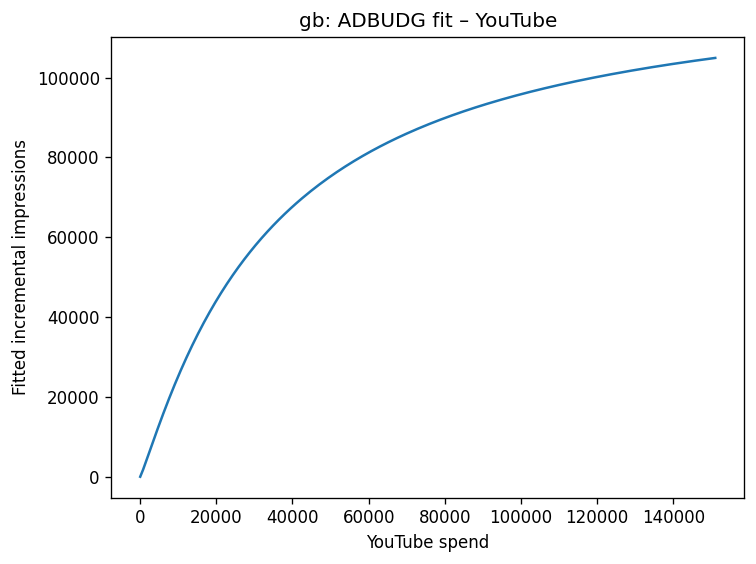

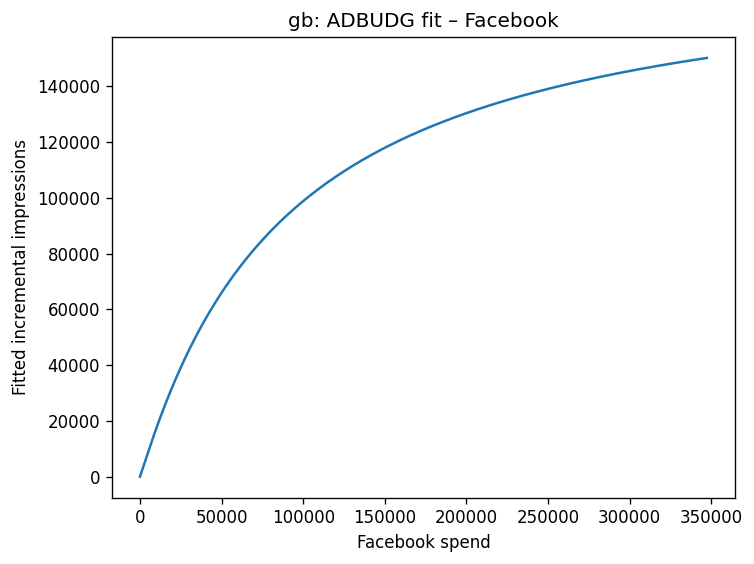

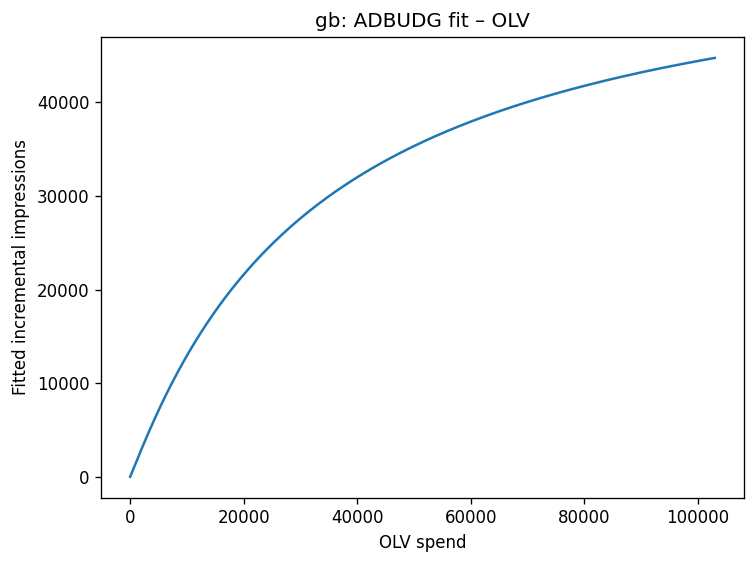

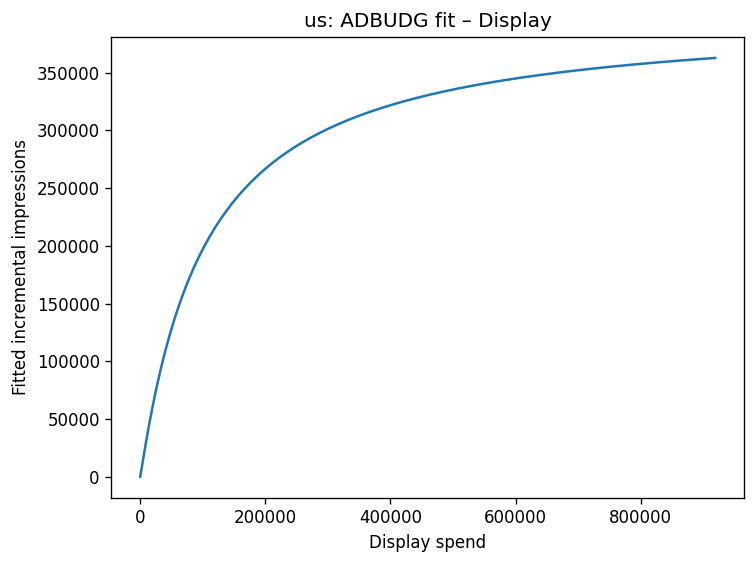

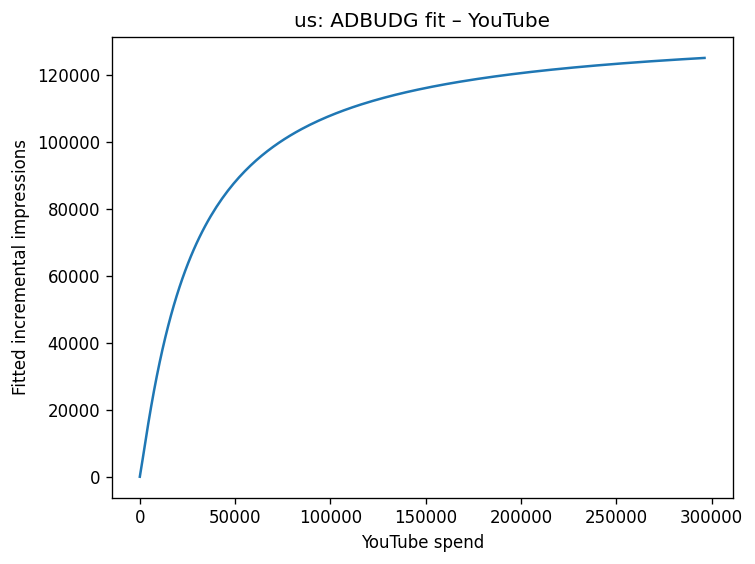

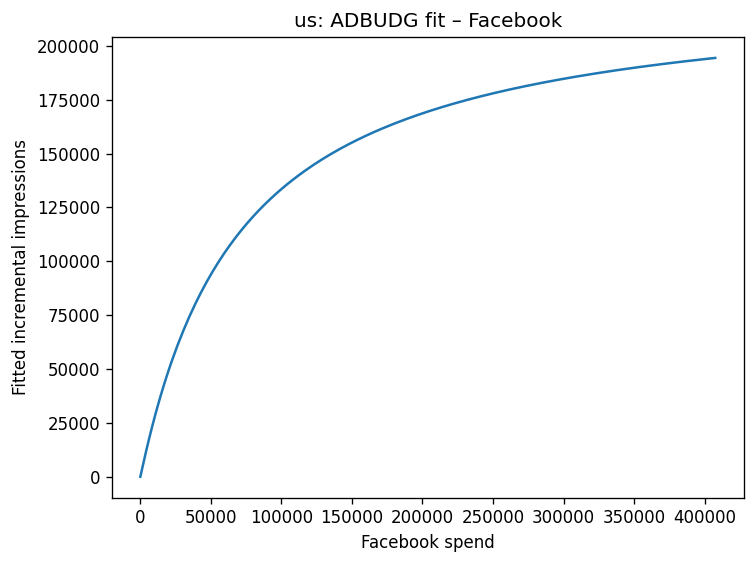

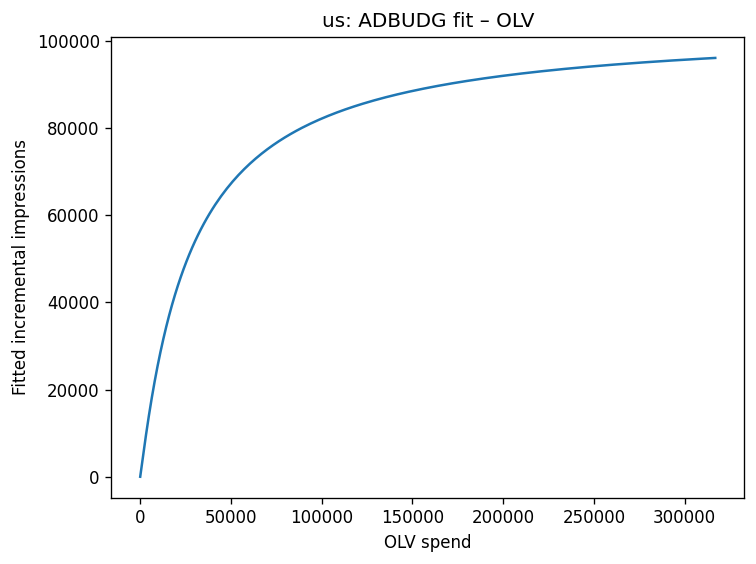

### ADBUDG Parameters (a, c, d)

,country,channel,a,c,d
0,de,Display,1.111511e+06,1.072409,2.256904e+06
1,de,YouTube,1.111511e+06,1.019597,1.293057e+06
2,de,Facebook,1.111511e+06,1.108471,3.506251e+06
3,de,OLV,1.111511e+06,1.083661,2.611254e+06
4,gb,Display,1.854136e+05,1.060867,1.063145e+05
5,gb,YouTube,1.254559e+05,1.109304,1.088169e+05
6,gb,Facebook,1.866587e+05,1.042023,1.440569e+05
7,gb,OLV,5.868092e+04,1.041602,5.183706e+04
8,us,Display,3.994849e+05,1.044686,1.717185e+05
9,us,YouTube,1.344447e+05,1.094463,7.320061e+04


### Elasticities (ADBUDG)

,country,channel,elasticity_ADBUDG_total,elasticity_ADBUDG_component
0,de,Display,0.211382,1.050837
1,de,YouTube,0.176034,1.001678
2,de,Facebook,0.405619,1.066305
3,de,OLV,0.242409,1.058852
4,gb,Display,0.259404,0.453337
5,gb,YouTube,0.186675,0.591326
6,gb,Facebook,0.254222,0.611026
7,gb,OLV,0.075270,0.673478
8,us,Display,0.257472,0.401325
9,us,YouTube,0.084793,0.360786


### Marginal Impressions per Dollar (ADBUDG)

,country,channel,marginal_impressions_per_dollar_ADBUDG
0,de,Display,1.047490
1,de,YouTube,1.026135
2,de,Facebook,1.035810
3,de,OLV,1.031283
4,gb,Display,0.667458
5,gb,YouTube,1.124648
6,gb,Facebook,0.739058
7,gb,OLV,0.742384
8,us,Display,0.612878
9,us,YouTube,0.610647


In [66]:
# Define digital channels for ADBUDG
channels_digital = [
    ('Display', 'display_net_spend_eur'),
    ('YouTube', 'yt_cost'),
    ('Facebook', 'fb_cost'),
    ('OLV', 'olv_net_spend_eur')
]

adb_params_rows, adb_elasticity_rows, adb_roi_rows = [], [], []

# Fit ADBUDG models by country for digital channels (outcome = total impressions)
for ctry in countries:
    dsub = df[df['country']==ctry].copy()
    if len(dsub) < 30:
        continue

    # Use total impressions across channels as y_inc
    y_inc = dsub[[col for _, col in channels_digital]].sum(axis=1).fillna(0.0).values.astype(float)

    # X matrix: channel spends
    Xmat = dsub[[col for _, col in channels_digital]].fillna(0.0).values.astype(float)
    y_scale = max(y_inc.mean(), 1.0)

    # Initial parameters a0, c0, d0
    a0 = [y_scale/len(channels_digital)] * len(channels_digital)
    c0 = [0.8] * len(channels_digital)
    d0 = [np.power(max(np.nanmedian(dsub[col].values), 1.0), 0.8) for _, col in channels_digital]
    p0 = np.array([val for triple in zip(a0, c0, d0) for val in triple], dtype=float)

    # Bounds
    lower, upper = [], []
    for _ in channels_digital:
        lower += [0.0, 0.1, 1e-6]
        upper += [10.0*y_scale, 3.0, 1e9]
    lower, upper = np.array(lower), np.array(upper)

    # Fit model
    res = least_squares(residuals_adbudg, p0, bounds=(lower, upper), args=(Xmat, y_inc))
    params = res.x

    # Plot fitted curves
    for j,(ch,col) in enumerate(channels_digital):
        a = params[3*j+0]; cpar = params[3*j+1]; dpar = params[3*j+2]
        xs = np.linspace(0, np.nanpercentile(dsub[col].values, 99), 200)
        ys = a * (np.power(xs, cpar) / (np.power(xs, cpar) + dpar + 1e-9))
        plt.figure()
        plt.plot(xs, ys)
        plt.xlabel(f"{ch} spend"); plt.ylabel("Fitted incremental impressions")
        plt.title(f"{ctry}: ADBUDG fit – {ch}")
        plt.tight_layout(); plt.show(); plt.close()

    # Store parameters and compute elasticities/marginal impressions per dollar
    for j,(ch,col) in enumerate(channels_digital):
        a = params[3*j+0]; cpar = params[3*j+1]; dpar = params[3*j+2]
        adb_params_rows.append({'country': ctry, 'channel': ch, 'a': a, 'c': cpar, 'd': dpar})
        Xbar = np.nanmean(dsub[col].values)
        if Xbar <= 0 or not np.isfinite(Xbar):
            e_component = np.nan; e_total = np.nan; m_ipd = np.nan
        else:
            num = Xbar**cpar
            e_component = cpar * dpar / (num + dpar)
            dfdX = a * cpar * dpar * (Xbar**(cpar-1)) / ((Xbar**cpar + dpar)**2)
            Ybar = np.nanmean(y_inc)
            e_total = dfdX * Xbar / Ybar if Ybar>0 else np.nan
            m_ipd = dfdX
        adb_elasticity_rows.append({'country': ctry, 'channel': ch,
                                    'elasticity_ADBUDG_total': e_total,
                                    'elasticity_ADBUDG_component': e_component})
        adb_roi_rows.append({'country': ctry, 'channel': ch,
                             'marginal_impressions_per_dollar_ADBUDG': m_ipd})

adb_params_df = pd.DataFrame(adb_params_rows)
adb_elasticity_df = pd.DataFrame(adb_elasticity_rows)
adb_roi_df = pd.DataFrame(adb_roi_rows)

display(Markdown('### ADBUDG Parameters (a, c, d)'))
display(adb_params_df)
display(Markdown('### Elasticities (ADBUDG)'))
display(adb_elasticity_df)
display(Markdown('### Marginal Impressions per Dollar (ADBUDG)'))
display(adb_roi_df)



## Model comparison

In [67]:
# Model comparison per country/channel for digital channels
comparison_rows = []

for ctry in countries:
    for ch, _ in channels_digital:  # use digital channels
        loglog_elast = elasticity_df[
            (elasticity_df['country']==ctry) &
            (elasticity_df['channel']==ch)
        ]['elasticity_loglog'].values

        adb_elast = adb_elasticity_df[
            (adb_elasticity_df['country']==ctry) &
            (adb_elasticity_df['channel']==ch)
        ]['elasticity_ADBUDG_total'].values

        if len(loglog_elast)==0 or len(adb_elast)==0:
            continue

        loglog_elast = loglog_elast[0]
        adb_elast = adb_elast[0]

        # Choose model with higher absolute elasticity
        if abs(loglog_elast) >= abs(adb_elast):
            best_model = 'Log-Log'
            best_elast = loglog_elast
        else:
            best_model = 'ADBUDG'
            best_elast = adb_elast

        comparison_rows.append({
            'country': ctry,
            'channel': ch,
            'best_model': best_model,
            'best_elasticity': best_elast
        })

comparison_df = pd.DataFrame(comparison_rows)

display(Markdown('### Model Comparison and Best Model Selection (Digital Channels - Impressions)'))
display(comparison_df)



### Model Comparison and Best Model Selection (Digital Channels - Impressions)

,country,channel,best_model,best_elasticity
0,de,Display,ADBUDG,0.211382
1,de,YouTube,ADBUDG,0.176034
2,de,Facebook,ADBUDG,0.405619
3,de,OLV,ADBUDG,0.242409
4,gb,Display,ADBUDG,0.259404
5,gb,YouTube,ADBUDG,0.186675
6,gb,Facebook,ADBUDG,0.254222
7,gb,OLV,Log-Log,0.085721
8,us,Display,Log-Log,0.360471
9,us,YouTube,ADBUDG,0.084793


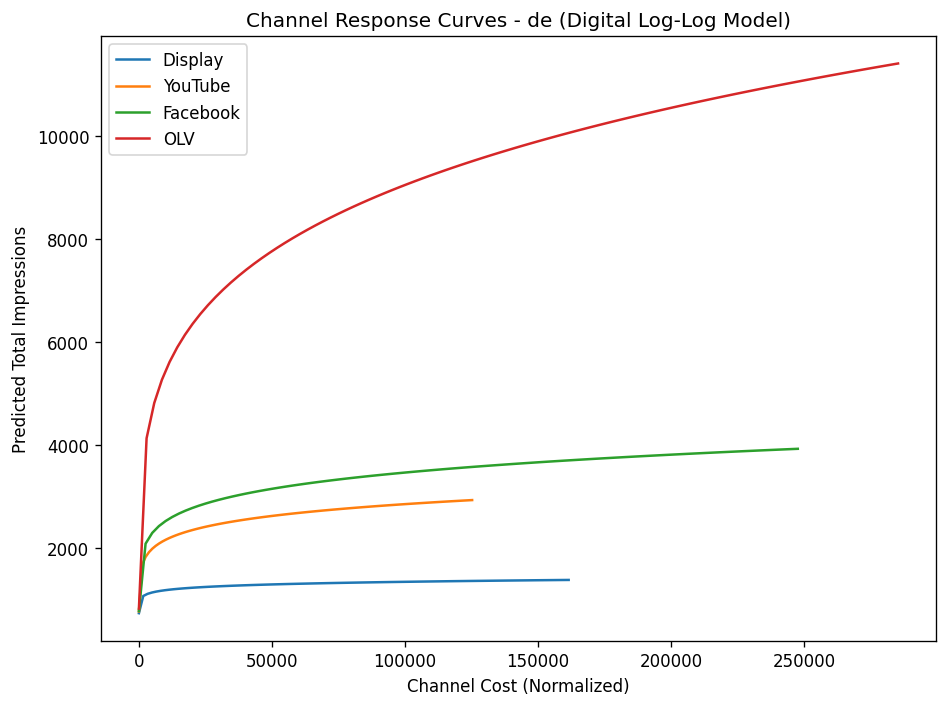

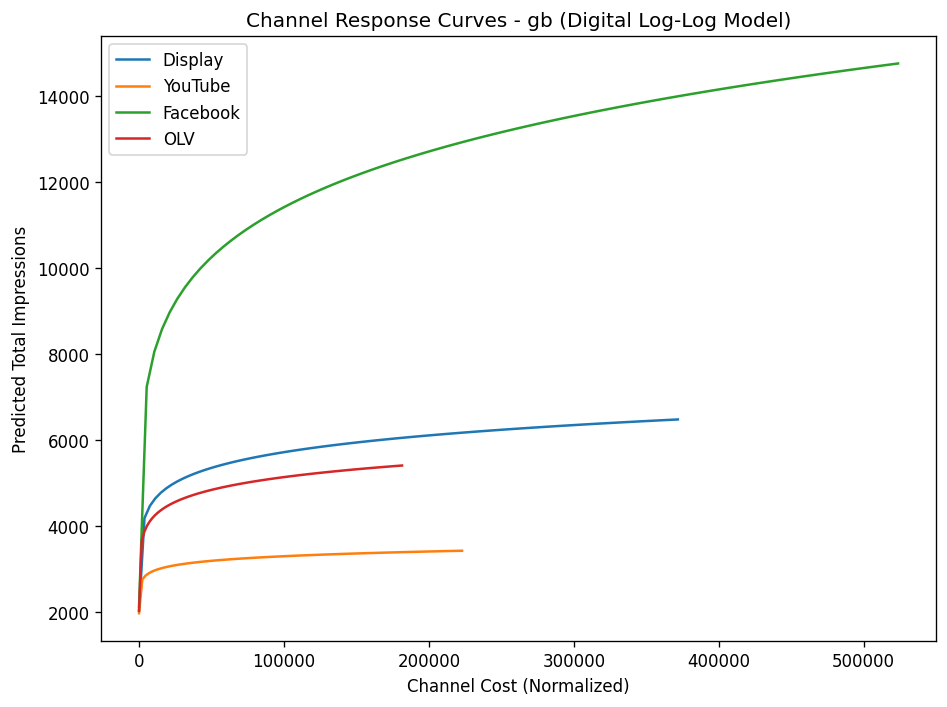

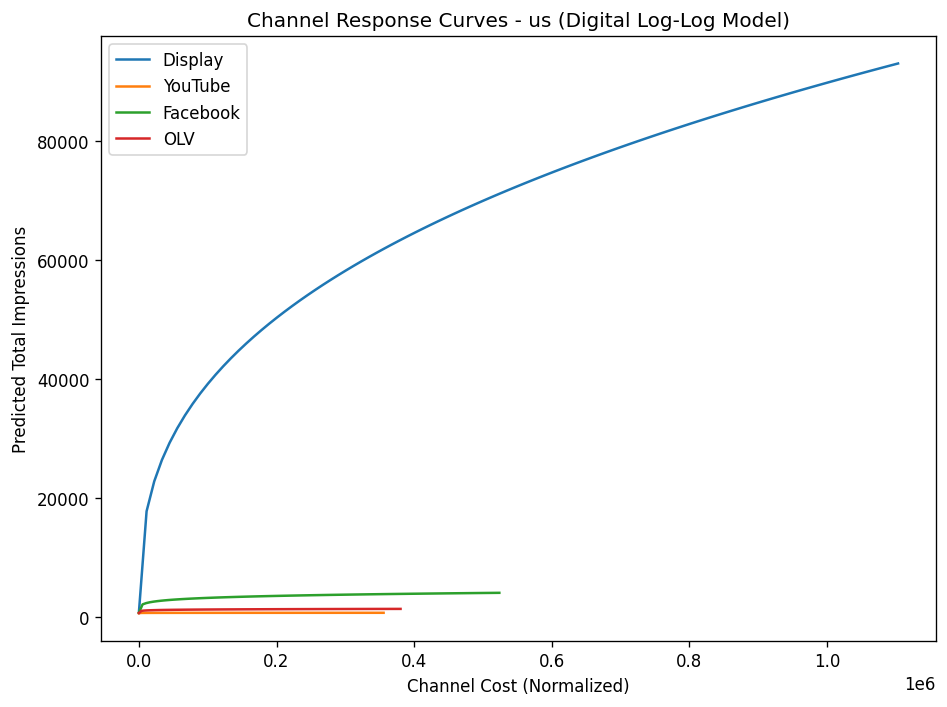

In [71]:
# Channel Response Curves (Log-Log) using total_impressions
cost_to_param = {
    'display_net_spend_eur' : 'ln_cost_display',
    'yt_cost'               : 'ln_cost_youtube',
    'fb_cost'               : 'ln_cost_facebook',
    'olv_net_spend_eur'     : 'ln_cost_olv'
}

for ctry in countries:
    dsub = df[df['country']==ctry].copy()
    if dsub['total_imps'].notna().sum() < 30:  # check enough data
        continue
    mdl = loglog_results[ctry]

    plt.figure(figsize=(8,6))

    for ch, col in channels_digital:
        beta = mdl.params.get(cost_to_param[col], np.nan)
        if np.isnan(beta) or not np.isfinite(beta):
            continue
        cost_range = np.linspace(1, dsub[col].max()*1.2, 100)
        pred_imps = np.exp(mdl.params['const'] + beta * np.log1p(cost_range))
        plt.plot(cost_range, pred_imps, label=ch)

    plt.xlabel('Channel Cost (Normalized)')
    plt.ylabel('Predicted Total Impressions')
    plt.title(f'Channel Response Curves - {ctry} (Digital Log-Log Model)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()



## Budget reallocation via elasticity ratios
Recommended shares ∝ elasticities (prefer log–log total; fallback to ADBUDG).

In [72]:
# Budget reallocation recommendations for digital channels (Impressions)
realloc_rows = []
for ctry in countries:
    dsub = df[df['country']==ctry].copy()

    # Digital channel spend columns (raw cost columns)
    spend_cols = {
        'Display': 'display_net_spend_eur',
        'YouTube': 'yt_cost',
        'Facebook': 'fb_cost',
        'OLV': 'olv_net_spend_eur'
    }

    # Current mean spend shares
    mean_spend = {ch: dsub[col].replace(0,np.nan).mean() for ch,col in spend_cols.items()}
    total_spend = np.nansum(list(mean_spend.values()))
    if total_spend<=0 or np.isnan(total_spend):
        continue
    curr_share = {ch: (val/total_spend if val>0 else 0.0) for ch,val in mean_spend.items()}

    # Elasticities from Log-Log and ADBUDG (impressions-based)
    e_adb = adb_elasticity_df[adb_elasticity_df['country']==ctry].set_index('channel')['elasticity_ADBUDG_total'].to_dict()
    e_ll = elasticity_df[elasticity_df['country']==ctry].set_index('channel')['elasticity_loglog'].to_dict()
    e_use = {}

    # Determine spend allocation based on elasticities
    for ch in spend_cols.keys():
        val = e_ll.get(ch, np.nan)
        if not np.isfinite(val) or pd.isna(val) or val<=0:
            val = e_adb.get(ch, np.nan)
        e_use[ch] = val if np.isfinite(val) and val>0 else 0.0

    sume = sum(e_use.values())
    if sume <= 0:
        continue
    rec_share = {ch: e_use[ch]/sume for ch in spend_cols.keys()}

    # Store recommended vs current share
    for ch in spend_cols.keys():
        realloc_rows.append({
            'country': ctry,
            'channel': ch,
            'current_share': curr_share.get(ch, np.nan),
            'recommended_share': rec_share.get(ch, np.nan),
            'shift_pp': 100*(rec_share.get(ch,0)-curr_share.get(ch,0))
        })

realloc_df = pd.DataFrame(realloc_rows)
display(Markdown('### Budget Reallocation Recommendations (Digital Channels, % point shifts)'))
display(realloc_df)




### Budget Reallocation Recommendations (Digital Channels, % point shifts)

,country,channel,current_share,recommended_share,shift_pp
0,de,Display,0.187351,0.103828,-8.352344
1,de,YouTube,0.257280,0.225750,-3.153007
2,de,Facebook,0.285793,0.257333,-2.846025
3,de,OLV,0.269575,0.413089,14.351375
4,gb,Display,0.376186,0.248037,-12.814918
5,gb,YouTube,0.227490,0.123493,-10.399686
6,gb,Facebook,0.274601,0.404651,13.005002
7,gb,OLV,0.121723,0.223819,10.209601
8,us,Display,0.366510,0.630333,26.382311
9,us,YouTube,0.203906,0.014384,-18.952179


## Diminishing returns flags
- **Log–log**: elasticity < 1 suggests diminishing returns at current level.
- **ADBUDG**: concavity **c < 1** indicates diminishing returns over observed range.

In [73]:
# Diminishing returns flags for digital channels (Log-Log, impressions)
dimret_rows = []
for idx, row in elasticity_df.iterrows():
    # Only include digital channels
    if row['channel'] not in [ch for ch, _ in channels_digital]:
        continue
    # Flag concave if elasticity < 1
    flag = (row['elasticity_loglog'] < 1.0)
    dimret_rows.append({
        'country': row['country'],
        'channel': row['channel'],
        'loglog_elasticity': row['elasticity_loglog'],
        'concave_flag': flag
    })

dimret_df = pd.DataFrame(dimret_rows)
display(Markdown('### Diminishing Returns Flags (Digital Channels, Log-Log)'))
display(dimret_df)


### Diminishing Returns Flags (Digital Channels, Log-Log)

,country,channel,loglog_elasticity,concave_flag
0,de,Display,0.055525,True
1,de,YouTube,0.120726,True
2,de,Facebook,0.137616,True
3,de,OLV,0.220910,True
4,gb,Display,0.094996,True
5,gb,YouTube,0.047297,True
6,gb,Facebook,0.154978,True
7,gb,OLV,0.085721,True
8,us,Display,0.360471,True
9,us,YouTube,0.008226,True


## Country summary (elasticities & reallocation)

In [74]:
# Country-level summary for digital channels (impressions-based)
summary_rows = []
digital_chs = [ch for ch,_ in channels_digital]

for ctry in sorted(set(elasticity_df['country']).union(set(adb_elasticity_df['country']))):
    # Elasticities from both models
    e_ll = elasticity_df[elasticity_df['country']==ctry].set_index('channel')['elasticity_loglog'].to_dict()
    e_adb = adb_elasticity_df[adb_elasticity_df['country']==ctry].set_index('channel')['elasticity_ADBUDG_total'].to_dict()
    combined = {}

    # Determine top 3 elastic channels (prefer ADBUDG if Log-Log missing or non-positive)
    for ch in digital_chs:
        v = e_ll.get(ch, float('nan'))
        if not pd.notna(v) or v <= 0:
            v = e_adb.get(ch, float('nan'))
        combined[ch] = v
    ranked = sorted(combined.items(), key=lambda kv: (-(kv[1] if pd.notna(kv[1]) else -1e9)))
    top3 = [f"{ch} ({val:.3f})" if pd.notna(val) else f"{ch} (NA)" for ch,val in ranked[:3]]

    # Budget reallocation (from realloc_df)
    re = realloc_df[realloc_df['country']==ctry].copy()
    top_up = re.sort_values('shift_pp', ascending=False).head(2)[['channel','shift_pp']].values.tolist()
    top_down = re.sort_values('shift_pp', ascending=True).head(2)[['channel','shift_pp']].values.tolist()

    summary_rows.append({
        'country': ctry,
        'Top elastic channels (pref ADBUDG)': ', '.join(top3),
        'Increase budget (pp)': ', '.join([f"{ch} (+{pp:.1f}pp)" for ch,pp in top_up]),
        'Cut budget (pp)': ', '.join([f"{ch} ({pp:.1f}pp)" for ch,pp in top_down])
    })

summary_df = pd.DataFrame(summary_rows)
display(Markdown('### Country-level Summary (Digital Channels: elasticities & reallocation)'))
display(summary_df)

# Save summary CSV
summary_df.to_csv(os.path.join(OUTPUT_DIR, 'country_summary_digital.csv'), index=False)
print('Saved country_summary_digital.csv to', OUTPUT_DIR)



### Country-level Summary (Digital Channels: elasticities & reallocation)

,country,Top elastic channels (pref ADBUDG),Increase budget (pp),Cut budget (pp)
0,de,"OLV (0.221), Facebook (0.138), YouTube (0.121)","OLV (+14.4pp), Facebook (+-2.8pp)","Display (-8.4pp), YouTube (-3.2pp)"
1,gb,"Facebook (0.155), Display (0.095), OLV (0.086)","Facebook (+13.0pp), OLV (+10.2pp)","Display (-12.8pp), YouTube (-10.4pp)"
2,us,"Display (0.360), Facebook (0.143), OLV (0.060)","Display (+26.4pp), Facebook (+3.0pp)","YouTube (-19.0pp), OLV (-10.5pp)"


Saved country_summary_digital.csv to /content/output


### Notes & assumptions
- Costs are normalized by `value_currency_rate` (\[cost\]/\[rate\]) to enable cross-country comparisons.
- Marginal ROI is computed using a weekly average booking value proxy: (sum of available performance-channel sales) / `totbookings` (median across time per country).
- The ADBUDG fit is static (no carryover).